## Imports

In [1]:
import pickle
import sys
import tempfile
import uuid
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

## Parameters

In [6]:
batch_size = 32
num_previous = 1000
d_model = 64
dropout = 0.1
dim_feedforward = 128
nhead = 8
num_encoder_layers = 2
#: Probability that a given history point is provided
mask_proba = 0.9

In [7]:
try:
    NOTEBOOK_PATH
    UNIQUE_PATH
except NameError:
    NOTEBOOK_PATH = Path("train_bert").resolve()
    NOTEBOOK_PATH.mkdir(exist_ok=True)
    unique_id = uuid.uuid4().hex[:8]
    UNIQUE_PATH = NOTEBOOK_PATH.joinpath(unique_id)
    UNIQUE_PATH.mkdir()
NOTEBOOK_PATH, UNIQUE_PATH

(PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_bert'),
 PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_bert/8c1940e6'))

In [8]:
device = torch.device("cuda:1")

### Load data

In [9]:
try:
    with Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name, "train_data_2.pkl").open("rb") as fin:
        TRAIN_TEST_SPLITS = pickle.load(fin)
except FileNotFoundError:
    %run prepare_training_data_2.ipynb
    temp_data_path = Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name)
    temp_data_path.mkdir(exist_ok=True)
    with temp_data_path.joinpath("train_data_2.pkl").open("wb") as fout:
        pickle.dump(TRAIN_TEST_SPLITS, fout, pickle.HIGHEST_PROTOCOL)

In [10]:
train_df, valid_df = TRAIN_TEST_SPLITS[-1]

In [11]:
train_df.head()

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0       0.0       0.0       0.0       0.5       0.5       0.5       0.5   
1       0.0       0.0       0.0       0.0       0.5       0.5       0.5   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
1       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
2       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
3       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
4       0.0       0.0       0.0        0.0        0.0        0.0        0.0   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0        0.5      -5.0      -5.0      -5.0      -5.0      -5.0      -5.0   
1        0.5      -5.0      -5.0      -5.0      -5.0      -5.0      -5.0   
2        0.0      -5.0      -5.0      -5.0      -5.0      -5.0      -5.0   
3        0.0      -5.0      -5.0      -5.0      -5.0      -5.0      -5.0   
4        0.0      -5.0      -5.0      -5.0      -5.0      -5.0      -5.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0      -5.0      -5.0      -5.0      -5.0       -5.0       -5.0       -5.0   
1      -5.0      -5.0      -5.0      -5.0       -5.0       -5.0       -5.0   
2      -5.0      -5.0      -5.0      -5.0       -5.0       -5.0       -5.0   
3      -5.0      -5.0      -5.0      -5.0       -5.0       -5.0       -5.0   
4      -5.0      -5.0      -5.0      -5.0       -5.0       -5.0       -5.0   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0  -4.298512  -3.482324       0.0       0.0       0.0       5.0       0.0   
1  -4.679509  -3.804566       0.0       0.0       0.0       0.0       2.0   
2  -5.000000  -4.126808       0.0       0.0       0.0       0.0       5.0   
3  -5.000000  -4.126808       0.0       0.0       0.0       0.0       5.0   
4  -5.000000  -4.126808       0.0       0.0       0.0       0.0       5.0   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
3       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
4       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        0.0        0.0        0.0  0.440309  0.115866 -0.686281  0.505571   
1        0.0        0.0        0.0  0.440309  0.115866 -0.686281  0.337880   
2        0.0        0.0        0.0  0.440309  0.115866 -0.686281  0.337880   
3        0.0        0.0        0.0  0.440309  0.115866 -0.686281  0.337880   
4        0.0        0.0        0.0  0.440309  0.115866 -0.686281  0.337880   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0  0.751304  0.257976  0.625241  0.727422  0.397151  0.474983   0.851544   
1  0.751304  0.257976  0.625241  0.727422  0.397151  0.474983   0.851544   
2  0.694997  0.257976  0.625241  0.727422  0.397151  0.474983   0.851544   
3  0.131923  0.257976  0.625241  0.727422  0.397151  0.474983   0.851544   
4 -0.149614  0.257976  0.625241  0.727422  0.397151  0.474983   0.851544   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0   0.381349   0.213408   0.387229   0.446392 -0.5  
1   0.381349   0.213408   0.387229   0.446392 -0.5  
2   0.381349   0.213408   0.387229   0.446392 -0.5  
3   0.381349   0.213408   0.387229   0.446392 -0.5  
4   0.381349   0.213408   0.387229

### Configure model

In [12]:
%%file {UNIQUE_PATH}/model.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    def __init__(self, data, num_previous=1) -> None:
        super().__init__()
        assert num_previous > 0
        values = data[:, :-1]
        targets = data[:, -1:]

        values = np.flip(values, 0)
        targets = np.flip(targets, 0)

        self.values = values.copy()
        self.targets = targets.copy()

        self.num_previous = num_previous

    def __len__(self):
        return self.targets.shape[0] - self.num_previous + 1

    def __getitem__(self, index):
        values = self.values[index : index + self.num_previous, :]
        targets = self.targets[index : index + self.num_previous, :]
        return values, targets


class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, max_previous, dropout):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_previous, d_model)
        position = torch.arange(0, max_previous).unsqueeze(1).to(torch.float32)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).to(torch.float32)
            * -(np.log(max_previous * 2) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #         pe = torch.flip(pe, (0,))
        #         pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        #         x = x + self.pe[:, -x.size(1) :]
        x = x + self.pe[:, : x.size(-1)]
        x = self.dropout(x)
        return x


class XTXModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        d_model=512,
        nhead=8,
        num_encoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        num_previous=100,
    ):
        super().__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_size, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
#             nn.LayerNorm(d_model),
        )
        self.pe = nn.Embedding(num_previous, d_model)

        self.pe = PositionalEncoding(d_model, num_previous, dropout=dropout)

        self.input_norm = nn.BatchNorm1d(num_previous)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            custom_decoder=None,
        )

        self.dropout_out = nn.Dropout(dropout)
        self.norm_out = nn.BatchNorm1d(num_previous)

        self.linear_out = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_size),
        )

        self.d_model = d_model

    def encoder(
        self, x, src_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None
    ):
        x = self.embedding(x)
        x = self.pe(x)
        src = x.transpose(0, 1)

        if src.size(2) != self.d_model:
            raise RuntimeError(
                "the feature number of src and tgt must be equal to d_model"
            )

        memory = self.transformer.encoder(
            src, mask=src_mask, src_key_padding_mask=src_key_padding_mask
        )
        src = src + self.dropout_out(memory)
        output = src.transpose(0, 1)
        return output

    def forward(
        self, x, src_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None
    ):
        output = self.encoder(x)
        output = self.linear_out(output)
        return output

Writing /home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_bert/8c1940e6/model.py


In [13]:
%run {UNIQUE_PATH}/model.py

In [14]:
pe = PositionalEncoding(128, 200, 0.1)

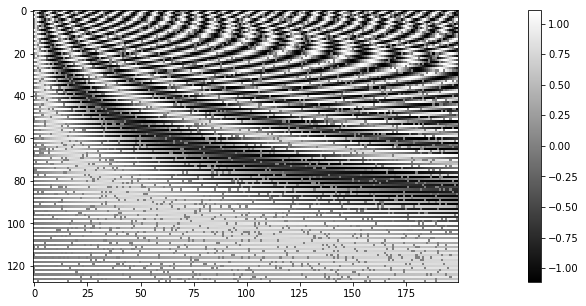

In [15]:
fg, ax = plt.subplots(figsize=(25, 5))
plt.imshow(pe(torch.zeros((1, 200, 128))).squeeze().data.numpy().T, cmap=plt.cm.get_cmap("gray"))
plt.colorbar()

In [16]:
train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous=num_previous)
valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous=num_previous)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# print(len(train1_indices), len(train2_indices))

In [19]:
net = XTXModel(
    61,
    1,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    num_previous=num_previous,
    dropout=dropout,
).to(device)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [21]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1)  # .transpose(0, 1)
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask

Epoch: 0
tensor(0.6917, device='cuda:1', grad_fn=<MseLossBackward>) 0.0270
tensor(0.5907, device='cuda:1', grad_fn=<MseLossBackward>) 0.1052
tensor(0.3856, device='cuda:1', grad_fn=<MseLossBackward>) -0.0392
tensor(0.4079, device='cuda:1', grad_fn=<MseLossBackward>) -0.2441
tensor(0.4430, device='cuda:1', grad_fn=<MseLossBackward>) -0.1057
tensor(0.3461, device='cuda:1', grad_fn=<MseLossBackward>) -0.4999
tensor(0.4231, device='cuda:1', grad_fn=<MseLossBackward>) -0.4849
tensor(0.3220, device='cuda:1', grad_fn=<MseLossBackward>) -0.1561
tensor(0.2920, device='cuda:1', grad_fn=<MseLossBackward>) -0.3507
tensor(0.2857, device='cuda:1', grad_fn=<MseLossBackward>) -0.1830
tensor(0.2683, device='cuda:1', grad_fn=<MseLossBackward>) -0.0134
tensor(0.2490, device='cuda:1', grad_fn=<MseLossBackward>) -0.0589
tensor(0.2157, device='cuda:1', grad_fn=<MseLossBackward>) -0.1108
tensor(0.2107, device='cuda:1', grad_fn=<MseLossBackward>) -0.3025
tensor(0.1593, device='cuda:1', grad_fn=<MseLossBackwar

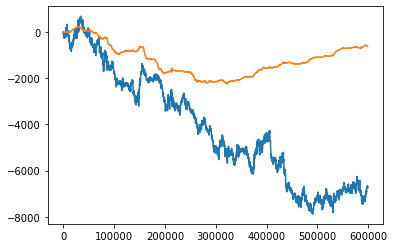

Train loss: 0.087620, Train score: -0.031235, Valid loss: 0.052166, Valid score: -0.005089, Balanced score: -0.010318
Epoch: 1
tensor(0.0664, device='cuda:1', grad_fn=<MseLossBackward>) -0.0194
tensor(0.0682, device='cuda:1', grad_fn=<MseLossBackward>) -0.4865
tensor(0.0581, device='cuda:1', grad_fn=<MseLossBackward>) -0.0770
tensor(0.0599, device='cuda:1', grad_fn=<MseLossBackward>) 0.1256
tensor(0.0511, device='cuda:1', grad_fn=<MseLossBackward>) 0.0046
tensor(0.0573, device='cuda:1', grad_fn=<MseLossBackward>) -0.1035
tensor(0.0787, device='cuda:1', grad_fn=<MseLossBackward>) -0.0196
tensor(0.0584, device='cuda:1', grad_fn=<MseLossBackward>) -0.0883
tensor(0.0662, device='cuda:1', grad_fn=<MseLossBackward>) 0.0292
tensor(0.0687, device='cuda:1', grad_fn=<MseLossBackward>) -0.0226
tensor(0.0649, device='cuda:1', grad_fn=<MseLossBackward>) -0.0661
tensor(0.0516, device='cuda:1', grad_fn=<MseLossBackward>) -0.0206
tensor(0.0672, device='cuda:1', grad_fn=<MseLossBackward>) -0.1001
tenso

KeyboardInterrupt: 

In [22]:
cpu = torch.device("cpu")

mask = torch.zeros(batch_size, num_previous, 1, dtype=torch.float32, device=device)
random_gen = torch.Generator(device=device)

# attn_mask = generate_square_subsequent_mask(num_previous).to(device)

max_balanced_score = -float("inf")
for epoch in range(60):
    print(f"Epoch: {epoch}")

    net.train()
    train_losses = []
    train_scores = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

#         mask.bernoulli_(mask_proba)
        mask[:, :, :] = 1
        mask[:, :1, :] = 0
        mask_slice = mask[: x.size(0), :, :]
        x_in = torch.cat([1 - mask_slice, x * mask_slice.expand_as(x)], dim=2)
        optimizer.zero_grad()
        x_out = net(x_in)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        score = 1 - ((y[:, 0, :] - x_out[:, 0, :]) ** 2).sum() / (y[:, 0, :] ** 2).sum()
        train_scores.append(score.item())
        if i % 100 == 0:
            print(loss, f"{score:.4f}")
    train_loss = sum(train_losses) / len(train_losses)
    train_score = sum(train_scores) / len(train_scores)

    net.eval()
    random_gen.manual_seed(42)
    valid_losses = []
    x_out_lst = []
    y_lst = []
    for i, batch in enumerate(valid_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

#         mask.bernoulli_(mask_proba, generator=random_gen)
        mask[:, :, :] = 1
        mask[:, :1, :] = 0
        mask_slice = mask[: x.size(0), :, :]
        x_in = torch.cat([1 - mask_slice, x * mask_slice.expand_as(x)], dim=2)
        with torch.no_grad():
            x_out = net(x_in)
        loss = criterion(x_out, y)
        valid_losses.append(loss.item())
        x_out_lst.append(x_out[:, 0, :].squeeze().squeeze().to(cpu).data.numpy())
        y_lst.append(y[:, 0, :].squeeze().to(cpu).data.numpy())
    valid_x_out = np.hstack(x_out_lst)
    valid_y = np.hstack(y_lst)
    valid_score = 1 - ((valid_y - valid_x_out) ** 2).sum() / (valid_y ** 2).sum()
    valid_loss = sum(valid_losses) / len(valid_losses)
    balanced_score = 0.8 * valid_score + 0.2 * min(0.04, train_score)

    fg, ax = plt.subplots()
    ax.plot(np.cumsum(valid_y), label='actual')
    ax.plot(np.cumsum(valid_x_out), label='predicted')
    fg.show()
    plt.show()

    print(
        f"Train loss: {train_loss:.6f}, Train score: {train_score:.6f}, "
        f"Valid loss: {valid_loss:.6f}, Valid score: {valid_score:.6f}, "
        f"Balanced score: {balanced_score:.6f}"
    )
    if balanced_score < max_balanced_score:
        break
    else:
        max_balanced_score = balanced_score

In [ ]:
y.to(cpu)[0, :, :].squeeze().shape

In [ ]:
x_out.to(cpu)[0, :, :].squeeze().shape

In [ ]:
    fg, ax = plt.subplots()
    ax.plot(np.cumsum(y.to(cpu)[0, :, :].squeeze().data), label='actual')
    ax.plot(np.cumsum(x_out.to(cpu)[0, :, :].squeeze().data), label='predicted')
    ax.plot(np.cumsum(x.to(cpu)[0, :, 0].squeeze().data * 95), label='predicted')
    fg.show()
    plt.show()
